# Electricity Customer에 대해서 수행

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import random
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_forecasting.metrics import SMAPE,RMSE,MAE
from captum.attr import IntegratedGradients,NoiseTunnel

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def MSE(pred,target):
    return torch.mean((pred-target)**2,dim = 0) # reduction까지 취해줌

## 1. 모델 구성하기
* 시간단위의 데이터로써 24x30 =720 즉 30일을 바라봄

In [3]:
data = pd.read_csv('../../GeneralData/ElectricityCustomer.csv')
sequence_length = 720
pred_len = 1

In [4]:
data = data.drop(columns='Unnamed: 0')

In [5]:
data = data[['customer2']]

In [6]:
data

,customer2
0,96.017070
1,93.172119
2,98.150782
3,87.482219
4,88.904694
...,...
8756,100.995733
8757,91.038407
8758,88.193457
8759,85.348506


<AxesSubplot: >

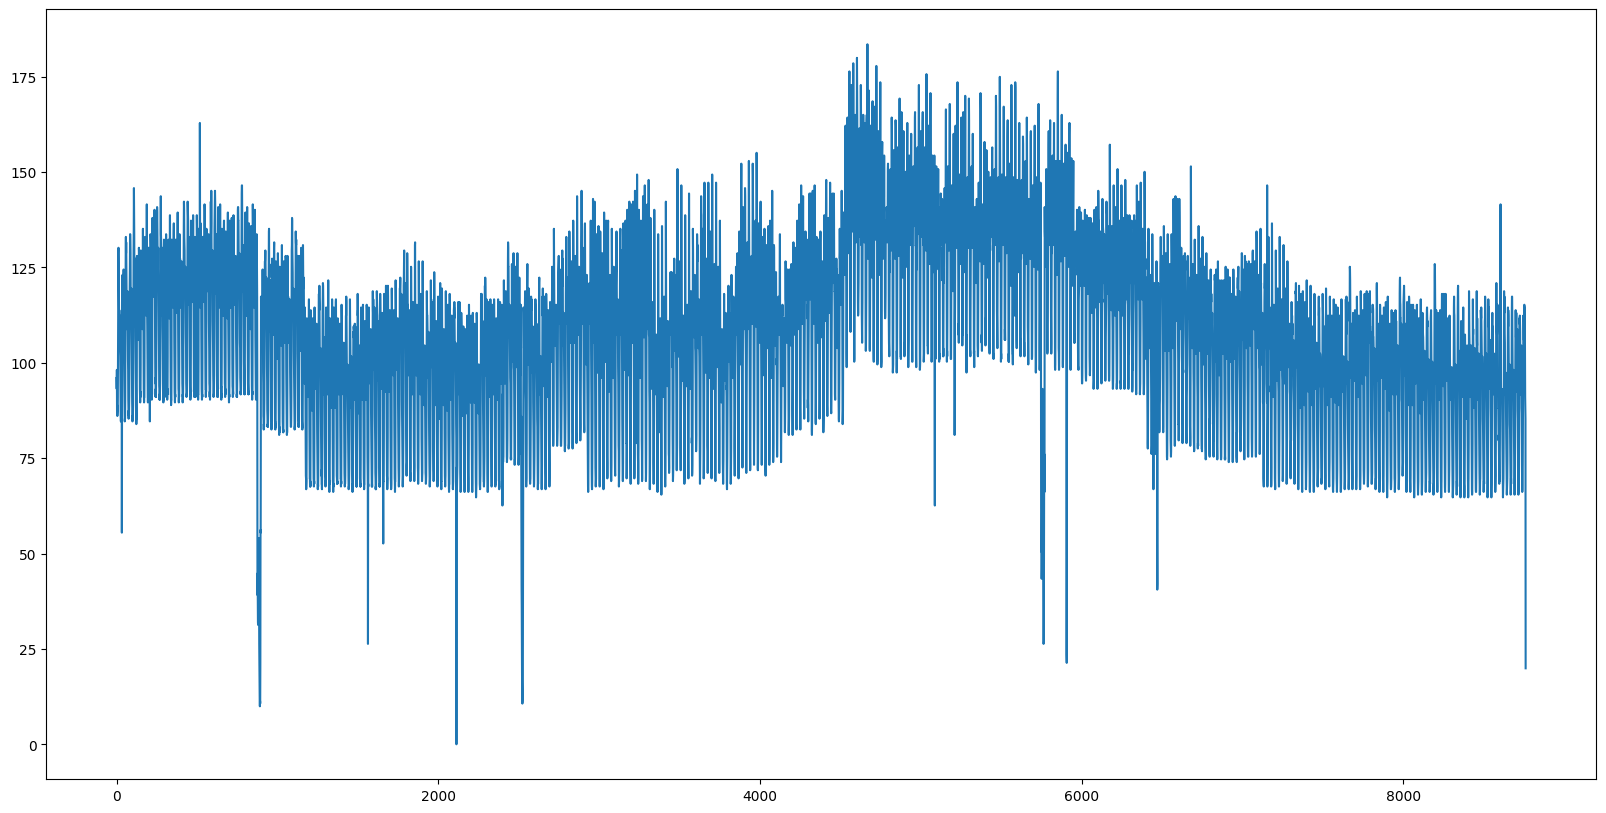

In [7]:
plt.figure(figsize=(20,10))
data['customer2'].plot()

In [8]:
from torch import FloatTensor as FloatTensor

In [9]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(len(x)-sequence_length):
        seq_list.append(x.iloc[i:i+sequence_length].values)
        target_list.append(x.iloc[i+sequence_length].values)

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [10]:
split = 24*7 # 24시간 x 7로써 1주일을 테스트셋으로 만듦

In [11]:
seed = 42

In [12]:
device = torch.device("cuda:0")

In [13]:
class Model(nn.Module):
    def __init__(self,train_index):
        super().__init__()
        self.seq_len = len(train_index)
        self.pred_len = 1
        self.train_index = train_index
        self.first_layer = nn.Linear(self.seq_len,self.pred_len)
        self.first_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
    def forward(self,x):
        return self.first_layer(x[:,:,self.train_index]) 

# 3. Train-Validation set으로 쪼개기

In [14]:
data

,customer2
0,96.017070
1,93.172119
2,98.150782
3,87.482219
4,88.904694
...,...
8756,100.995733
8757,91.038407
8758,88.193457
8759,85.348506


* 8761개 중 일주일치 데이터인 168개의 데이터를 Test Set
* 8761 중 0.2의 비율인 1752개는 validation set
* 8761개 중 0.8의 비율인 7009개는 train set

In [15]:
val_num = 1752

In [16]:
train = data.iloc[:-split-val_num]
val = data.iloc[-split-val_num:-split]
x_train,y_train = seq_data(train, sequence_length = sequence_length, pred_len = pred_len)
x_val,y_val = seq_data(val, sequence_length = sequence_length, pred_len = pred_len)
train_dataset = TensorDataset(x_train,y_train)
val_dataset = TensorDataset(x_val,y_val)
training = DataLoader(train_dataset,batch_size=64)
validation = DataLoader(val_dataset,batch_size=64)

/tmp/ipykernel_755678/2654461304.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [17]:
next(iter(validation))[0].size()

torch.Size([64, 1, 720])

### 위와 같은 방식으로 validation-set에 대해서 기여도를 구하면 될 것이다.
-> 모든 batch의 각 sample에 대해서 Ig를 통한 attribution을 구해서 모든 batch에 걸쳐서 더한후 그것을 평균시킨다.<br>
-> 결과적으로 모든 validation set에 대한 attribution을 평균한다.

In [18]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
train_index = np.arange(sequence_length)
model = Model(train_index).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
num_epochs = 100
n= len(training)

### 기본 모델 training

In [19]:
import copy

In [20]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
minimal_loss=np.inf
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
        
        outputs = outputs.view(-1,1)
        labels = labels.view(-1,1)
        
        # defining loss
        loss = MSE(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)*100))
    if (running_loss/n)*100<minimal_loss:
        best_model = copy.deepcopy(model)
        minimal_loss = (running_loss/n)*100
        print("changed")

model = best_model

Epoch [1]/[100] running accumulative loss across all batches: 33383.352
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
Epoch [21]/[100] running accumulative loss across all batches: 15021.483
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
Epoch [41]/[100] running accumulative loss across all batches: 12907.438
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
Epoch [61]/[100] running accumulative loss across all batches: 10967.192
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
Epoch [81]/[100] running accumulative loss across all batches: 9436.2

### validation set에 대해서 attribution 구하기

In [21]:
n = len(validation)
n

17

In [22]:
cnt = 0
ig = IntegratedGradients(model)
nt_ig = NoiseTunnel(ig)
nt_ig_attr_score = torch.zeros((1,sequence_length))
for val in validation:
    temp_n = val[0].size(0)
    temp = nt_ig.attribute(val[0]).sum(axis = 0) # axis=0으로 batch axis를 기준으로 다 더했음
    nt_ig_attr_score = nt_ig_attr_score.to(device)+temp
    cnt = cnt + temp_n
nt_ig_attr_score = nt_ig_attr_score/cnt
nt_ig_attr_score = nt_ig_attr_score.cpu().numpy().reshape(-1)

In [23]:
len(nt_ig_attr_score)

720

<AxesSubplot: >

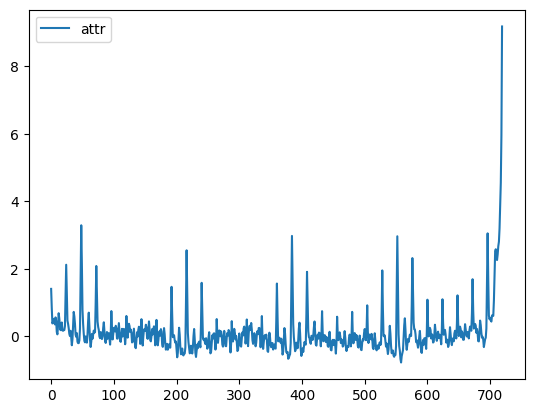

In [24]:
attr_df = pd.DataFrame({'attr':nt_ig_attr_score})
attr_df.plot()

### &rightarrow; 최근데이터가 매우강조 되는것을 확인할 수 있다.

#### scaling

* 표준화는 데이터가 정규분포를 따른다고 가정해야지 1sigma와 -1sigma에 68%정도의 데이터가 모여있음
* 데이터를 z-score로 변환(즉, 데이터를 표준화 또는 정규화)한다고 해서 데이터가 정규분포가 되는 것은 아니다. 단지 비교를 목적으로 데이터를 표준정규분포와 같은 척도로 만드는 것 뿐이다.
* 결과적으로 원래 정규분포의 형태였던 분포를 공통척도(평균은 0 표준편차는 1)로 바꾸는 것

https://hleecaster.com/ml-normalization-concept/

<AxesSubplot: >

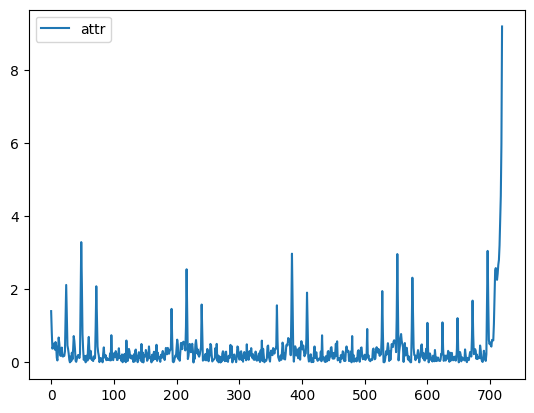

In [25]:
attr_df = attr_df.abs()
attr_df.plot()

## Outlier정의

In [26]:
IQR = 1.5*(attr_df.quantile(0.75)-attr_df.quantile(0.25))
outlier_max = attr_df.quantile(0.75)+IQR
outlier_min = attr_df.quantile(0.25)-IQR
candidate_attr = attr_df[(attr_df>=outlier_min) & (attr_df<=outlier_max)]
candidate_attr = candidate_attr.dropna()
candidate_attr

,attr
2,0.378402
3,0.431535
4,0.515919
5,0.465913
6,0.351649
...,...
701,0.467034
702,0.434752
703,0.617035
704,0.605048


In [27]:
outlier_max

attr    0.787774
dtype: float64

In [28]:
outlier_min

attr   -0.32484
dtype: float64

<AxesSubplot: >

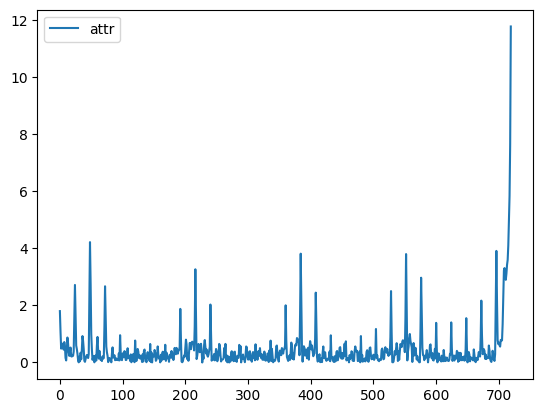

In [29]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
scaler.fit(candidate_attr.values)
m_attr_df = scaler.transform(attr_df.values)
m_attr_df = pd.DataFrame({"attr":m_attr_df.reshape(-1)})
# attr_df = attr_df.abs()
# attr_std = attr_df.std().item()
# attr_min = attr_df.min().item()
m_attr_df.plot()

In [30]:
m_attr_df.describe()

,attr
count,720.000000
mean,0.459212
std,0.817025
min,0.000000
25%,0.117785
50%,0.256407
75%,0.474716
max,11.782187


## 0과 1사이의 분포 확인하기

In [31]:
m_attr_df[(m_attr_df>=0) & (m_attr_df<=1)].dropna()

,attr
2,0.484800
3,0.552982
4,0.661265
5,0.597096
6,0.450470
...,...
701,0.598534
702,0.557109
703,0.791018
704,0.775636


* outlier를 제외하면 들어와있음을 확인할 수 있다.

<AxesSubplot: >

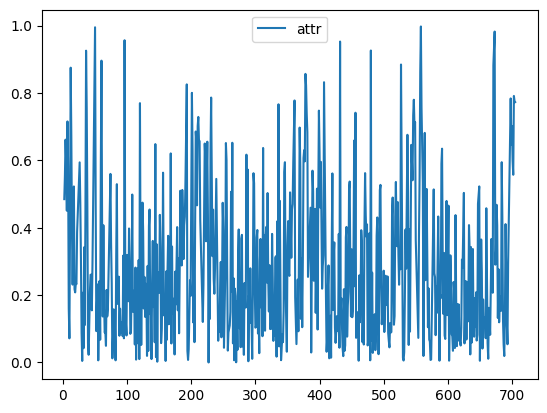

In [32]:
m_attr_df[(m_attr_df>=0) & (m_attr_df<=1)].dropna().plot()

### MinMaxScaler와 비교

<AxesSubplot: >

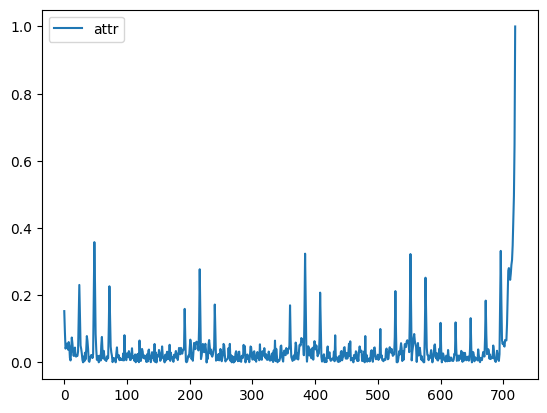

In [33]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
attr_df = scaler.fit_transform(attr_df.values)
attr_df = pd.DataFrame({"attr":attr_df.reshape(-1)})
# attr_df = attr_df.abs()
# attr_std = attr_df.std().item()
# attr_min = attr_df.min().item()
attr_df.plot()

#### train_index구하기

In [34]:
index_list = []

for hyper_para in np.arange(0.00,1.01,0.01):
    append_idx = list(m_attr_df[(m_attr_df['attr']>=hyper_para)].index)
    index_list.append(append_idx)
len(index_list) # train_index의 리스트

101

In [35]:
len_list=[]
for i in range(101):
    len_list.append(len(index_list[i]))


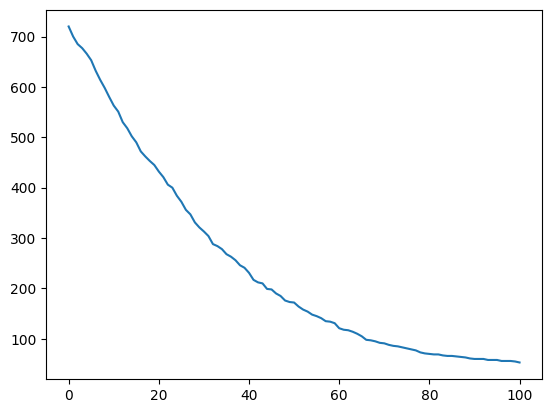

In [36]:
plt.plot(np.arange(101),len_list) # 포함되는 time_index의 갯수

In [37]:
### 원래 난수가 선언된 위치
m = len(validation)
n = len(training)
cnt = 0
mse_out_list = []
mae_out_list = []
smape_out_list = []
rmse_out_list = []
num_epochs = 100
for idx in index_list: #0.01~1.00 100개의 index에 대해서 수행
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
    train_idx = idx
    minimal_loss=np.inf
    model = Model(train_idx).to(device) # 모델 초기화
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer 초기화
    result = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in training:
            # forward pass
            inputs = inputs
            
            outputs = model(inputs)
            outputs = outputs.view(-1,1)
            labels = labels.view(-1,1)            
            # defining loss
            loss = MSE(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch == 99:    
            print(f'{cnt}번째 모델 Training 완료 마지막 Epoch loss:{(running_loss/n)*100}')
        
        if (running_loss/n)*100<minimal_loss:
            best_model = copy.deepcopy(model)
            minimal_loss = (running_loss/n)*100
            print("changed")

    model = best_model
    cnt+=1
    # 모델 Fully-Training 완료
    
    pred = torch.FloatTensor().to(device)
    val_target = torch.FloatTensor().to(device)
    for val_x,val_y in validation:
        tmp_pred = model(val_x)
        pred = torch.concat([pred,tmp_pred], dim=0)
        val_target = torch.concat([val_target,val_y],dim = 0)
    pred = pred.view(-1,1)
    val_target = val_target.view(-1,1)
    result = MSE(pred,val_target).item()
    mse_out_list.append(result)
    mae_out_list.append(MAE()(pred,val_target).item())
    rmse_out_list.append(RMSE()(pred,val_target).item())
    smape_out_list.append(SMAPE()(pred,val_target).item()*100)

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
0번째 모델 Training 완료 마지막 Epoch loss:8302.422738075256
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
chan

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
9번째 모델 Training 완료 마지막 Epoch loss:8280.420768260956
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
chan

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
19번째 모델 Training 완료 마지막 Epoch loss:8001.251365741094
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
changed
changed
changed
changed
changed
28번째 모델 Training 완료 마지막 Epoch loss:7585.417465368907
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
29번째 모델 Training 완료 마지막 Epoch loss:7531.9878667593
changed
changed
changed
changed


changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
38번째 모델 Training 완료 마지막 Epoch loss:7195.014120141665
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
48번째 모델 Training 완료 마지막 Epoch loss:6984.335541725159
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
57번째 모델 Training 완료 마지막 Epoch loss:6858.404080073039
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
67번째 모델 Training 완료 마지막 Epoch loss:6948.1382836898165
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
ch

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
77번째 모델 Training 완료 마지막 Epoch loss:7510.2771153052645
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
ch

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
86번째 모델 Training 완료 마지막 Epoch loss:8753.747465213139
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
96번째 모델 Training 완료 마지막 Epoch loss:9036.238414049149
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

In [38]:
val_y # 다음 예측 타겟값

tensor([[[115.2205]],

        [[110.9531]],

        [[105.9744]],

        [[ 96.0171]],

        [[ 88.1935]],

        [[ 88.1935]],

        [[ 84.6373]],

        [[ 79.6586]]], device='cuda:0')

In [39]:
val_x # 예측 하는 값

tensor([[[105.2632, 111.6643, 112.3755,  ..., 107.3969, 108.1081, 110.9531]],

        [[111.6643, 112.3755, 110.2418,  ..., 108.1081, 110.9531, 115.2205]],

        [[112.3755, 110.2418, 108.8193,  ..., 110.9531, 115.2205, 110.9531]],

        ...,

        [[ 92.4609,  86.7710,  76.1024,  ..., 105.9744,  96.0171,  88.1935]],

        [[ 86.7710,  76.1024,  69.7013,  ...,  96.0171,  88.1935,  88.1935]],

        [[ 76.1024,  69.7013,  67.5676,  ...,  88.1935,  88.1935,  84.6373]]],
       device='cuda:0')

In [40]:
result/68

0.5944309795604032

In [41]:
val_x.size()

torch.Size([8, 1, 720])

         out
59  26.45734


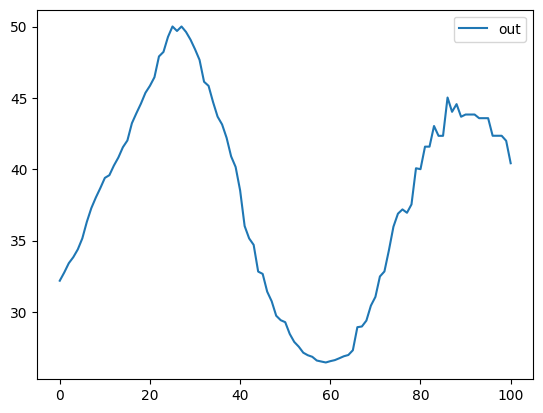

In [42]:
out_df = pd.DataFrame({"out":mse_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

         out
59  3.603041


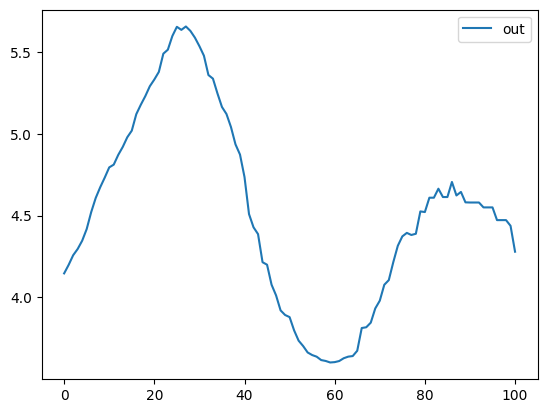

In [43]:
out_df = pd.DataFrame({"out":mae_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

         out
59  3.822324


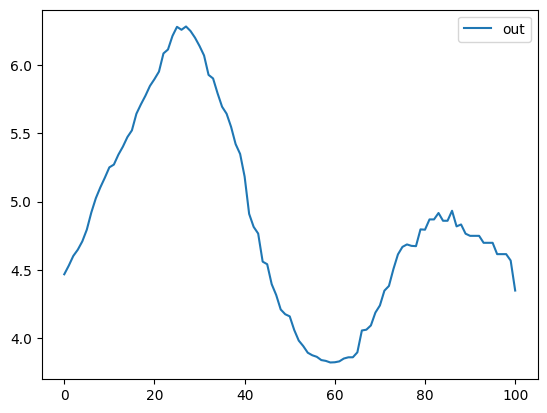

In [44]:
out_df = pd.DataFrame({"out":smape_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

        out
59  5.14367


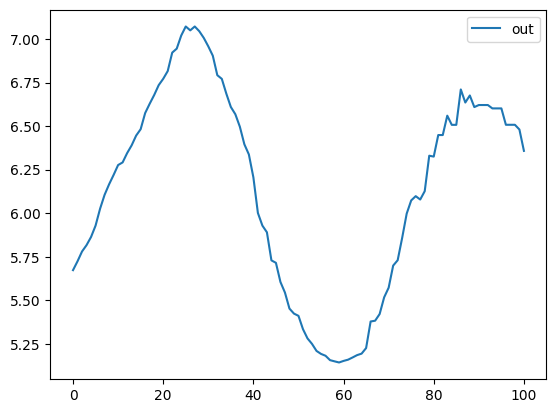

In [45]:
out_df = pd.DataFrame({"out":rmse_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [46]:
attr_df.describe()

,attr
count,720.000000
mean,0.038975
std,0.069344
min,0.000000
25%,0.009997
50%,0.021762
75%,0.040291
max,1.000000
